In [ ]:

import Pkg; Pkg.add("NLsolve")
Pkg.add("Plots")
Pkg.add("LaTeXStrings")
Pkg.add("LinearAlgebra")

In [1]:
import Pkg; Pkg.add("ColorSchemes")

   Resolving package versions...
package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`


## Annealer with Multiprocessing 

## USED TO SUCK, Now it does better


In [3]:

# ---------------------------
# VECTORIZED SOLVER
# ---------------------------

using NLsolve
using LinearAlgebra
using Plots
using LaTeXStrings

In [4]:
using NLsolve, Distributed
# # Add 22 workers for multiprocessing
# nprocs() < 2 && addprocs(22)  # Add 22 workers if not already added

In [23]:
@everywhere begin
    # ---------------------------
    # PARAMETERS
    # ---------------------------
    n = 20
    kappa = 1.0
    d = 4
    b = 4 / (3 * π)
    epsilon = 0.03
    delta = 1.0
    
    alphas = range(3.0, stop=5.0, length=30)
    P_values=  [1600] #d .^ alphas
    chi_list = [25.0]

end

In [ ]:

# Add worker processes for multiprocessing (replace '20' with desired number of cores, or use Sys.CPU_threads() )
# The Julia session must be started with multiple processes or threads:
# For processes (like this example, separate memory spaces):
# julia -p 20 script.jl 
# For threads (shared memory):
# julia --threads 20 script.jl 
# Using Distributed.addprocs(20) at runtime is also an option.
# We'll use pmap later for distributed processing over 'chi_list' (or another outer loop).
@everywhere begin

    const vars_len = 9  # lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT
    const prev_sol_initial = fill(0.1, vars_len) # Initial guess for the first chi and P

    const chi0_val = 1e-8 # Initial chi value for annealing
    const annealing_steps = 30000 # Number of steps to anneal chi
   
    function is_physical(sol)
        return all(sol[[3,4,7,8]] .> 0)
    end
    # ---------------------------
    # SYSTEM OF EQUATIONS (unchanged)
    # ---------------------------
    function equations!(F, x, P, chi, d, kappa, delta, epsilon, n, b)
        lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT = x
        lWP = 1/d
        TrSigma = lWT + lWP*(d-1)
        
        EChh = lH1 + lH3 +
            (16 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3))*(d-1) +
            (4 / (π * (1 + 2*TrSigma)) * lWT)*(d-1)
        gammaYh2 = (4/π)/(1 + 2*EChh)
        lK1 = gammaYh2*lH1
        lK3 = gammaYh2*lH3

        F[1] = lT1 + chi^2 / (kappa / P + lK1)^2 * delta
        F[2] = lV1 - (lH1 / lJ1^2 - 1 / lJ1)
        F[3] = lH1 - 1 / (1/lJ1 + gammaYh2*lT1/(n*chi))
        F[4] = lJ1 - (4 / (π * (1 + 2*TrSigma)) * lWT)
        
        F[5] = lT3 + chi^2 / (kappa / P + lK3)^2 * delta
        F[6] = lV3 - (lH3 / lJ3^2 - 1 / lJ3)
        F[7] = lH3 - 1 / (1/lJ3 + gammaYh2*lT3*epsilon^2/(n*chi))
        F[8] = lJ3 - (16 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3))
        F[9] = lWT - 1 / (d + delta * b * lV1 / n)
    end

    # ---------------------------
    # HELPER FUNCTIONS (unchanged, assuming constants are globally available or passed)
    # ---------------------------
    is_physical(sol) = all(sol[[3,4,7,8]] .> 0)

    function compute_lK_ratio(sol, P, dval, kappa)
        if sol === nothing
            return (NaN, NaN)
        end
        lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT = sol

        lWP = 1/dval
        TrSigma = lWT + lWP*(dval-1)
        EChh = lH1 + lH3 +
            (16/ (π * (1 + 2*TrSigma)^3) * (15*lWT^3))*(dval-1) +
            (4 / (π * (1 + 2*TrSigma)) * lWT)*(dval-1)
        gammaYh2 = (4/π)/(1 + 2*EChh)
        lK1 = gammaYh2*lH1
        lK3 = gammaYh2*lH3
        return (lK1/(lK1 + kappa/P), lK3/(lK3 + kappa/P))
    end

    # ---------------------------
    # CORE SOLUTION FUNCTION with CHI ANNEALING
    # ---------------------------

    # Solves for a single final_chi value over all P_values, using chi annealing.
    # Assumes d, kappa, delta, epsilon, n, b are available or passed.
    function solve_with_annealing(final_chi, P_values, chi0, initial_guess, 
                                    d, kappa, delta, epsilon, n, b)
        println("Solving $final_chi")
        
        # 1. Chi Annealing Steps (log-spaced)
        chi_anneal_list = exp.(range(log(chi0), log(final_chi), length=annealing_steps))
        # chi_anneal_list = range(chi0, stop=final_chi, length=annealing_steps)
        
        # Initialize continuation: Start at chi0 solution, then continue with P_values
        prev_sol = initial_guess # Use the provided initial guess for the first chi and P
        
        # Store results for this final_chi
        sols = Vector{Union{Vector{Float64},Nothing}}(undef, length(P_values))
        sol_lH3s = zeros(length(P_values), length(chi_anneal_list))

            
        for (i, P) in enumerate(P_values)
            # 2. Anneal chi up to final_chi
            new_prev_sol = prev_sol
            for (j, chi) in enumerate(chi_anneal_list)
                f!(F,x) = equations!(F, x, P, chi, d, kappa, delta, epsilon, n, b)
                if (final_chi == 10) & (chi >= final_chi)
                    # println(chi)
                    # if !(is_physical(sol))
                    #     println(sol * string(i))
                    # else 
                    #     # println("Finished solving P=" * string(P) * "and chi=" * string(chi))
                    # end
                end
                try
                    sol = nlsolve(f!, new_prev_sol, method=:newton, xtol=1e-8).zero
                    sols[i] = sol
                    sol_lH3s[i,j] = sol[7]
                    
                    # Only store if it's the final chi in the annealing list
                    if (i==length(chi_anneal_list)) 
                        # println(is_physical(sol))
                        # if !(is_physical(sol))
                        #     println(sol * string(i))
                        # else 
                        #     # println("Finished solving P=" * string(P) * "and chi=" * string(chi))
                        # end
                        if !is_physical(sol)
                            println("FAILED: ")
                        end
                        sols[i] = is_physical(sol) ? sol : sols[i]
                    end
                    
                    new_prev_sol = sol  # Continuation for P (within the same chi step)
                catch e
                    println("FAILS!")
                    # If a solve fails, stick with the previous solution for continuation
                    if chi >= final_chi
                        sols[i] = nothing
                    end
                end
            end
        end
        
        return (final_chi, sols, sol_lH3s)
    end
end
# ---------------------------
# MULTIPROCESSING
# ---------------------------

# Use 'pmap' (Parallel Map) to distribute the computation over multiple processes (cores).
# Assumes 'd', 'kappa', 'delta', 'epsilon', 'n', 'b' are defined globally or passed to the scope.
# The 'chi_list' is the set of maximum chi values to be solved.
# Each worker process will execute 'solve_with_annealing' for one final_chi value.

println("Starting parallel computation on $(nworkers()) workers...")

# pmap distributes the function call over the elements of chi_list
parallel_results = pmap(chi -> solve_with_annealing(chi, P_values, chi0_val, prev_sol_initial, d, kappa, delta, epsilon, n, b), chi_list)

# Re-package the results into the desired dictionary format


# ---------------------------
# POSTPROCESS (unchanged)
# ---------------------------
function extract_series(var_idx)
    Dict(chi => [sol===nothing ? NaN : sol[var_idx] for sol in results[chi]] for chi in chi_list)
end
# results

Starting parallel computation on 1 workers...
Solving 25.0


extract_series (generic function with 1 method)

In [30]:
results = Dict(r[1] => r[2] for r in parallel_results)


Dict{Float64, Vector{Union{Nothing, Vector{Float64}}}} with 1 entry:
  25.0 => [[-10652.4, 61.7559, 0.512355, 0.0833476, -4.6025e6, 4.26342, 0.02338…

In [31]:

lH1_series = extract_series(3)
lH3_series = extract_series(7)
lJ1_series = extract_series(4)
lJ3_series = extract_series(8)

lK_ratio = Dict(chi => [compute_lK_ratio(sol, P_values[i], d, kappa) for (i,sol) in enumerate(results[chi])] for chi in chi_list)

Dict{Float64, Vector{Tuple{Float64, Float64}}} with 1 entry:
  25.0 => [(0.99742, 0.946366)]

In [32]:
lH1_series, lH3_series

(Dict(25.0 => [0.5123554581266296]), Dict(25.0 => [0.023387284937602726]))

In [33]:
lJ1_series, lJ3_series

(Dict(25.0 => [0.08334762584511929]), Dict(25.0 => [0.02142943464375885]))

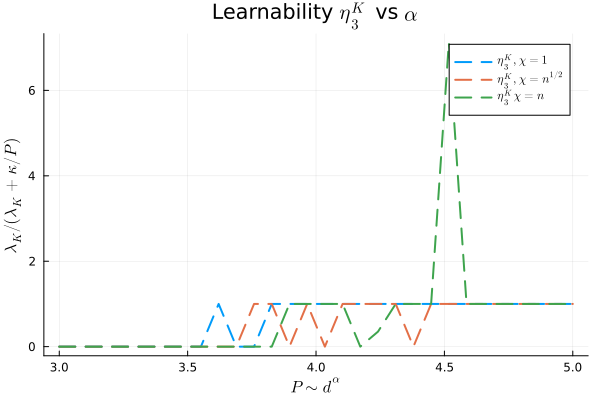

In [9]:

plot(alphas, [r[2] for r in lK_ratio[1]], label=L"\eta^K_3,\chi=1", lw=2, ls=:dash)
plot!(alphas, [r[2] for r in lK_ratio[n^0.5]], label=L"\eta^K_3, \chi=n^{1/2}", lw=2, ls=:dash)
plot!(alphas, [r[2] for r in lK_ratio[n]], label=L"\eta^K_3 \chi=n", lw=2, ls=:dash)

xlabel!(L"$P \sim d^\alpha$"); ylabel!(L"\lambda_K/(\lambda_K + \kappa/P)"); 
title!("Learnability " * L" \eta^K_3 " * " vs " *L" \alpha ")


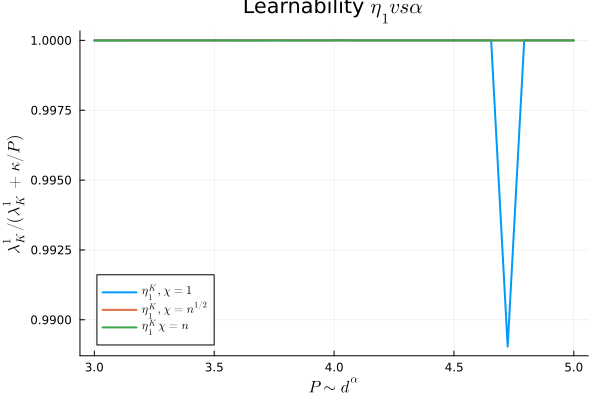

In [10]:
using LaTeXStrings
plot(alphas, [r[1] for r in lK_ratio[1]], label=L"\eta^K_1,\chi=1", lw=2)
plot!(alphas, [r[1] for r in lK_ratio[n^0.5]], label=L"\eta^K_1, \chi=n^{1/2}", lw=2)
plot!(alphas, [r[1] for r in lK_ratio[n]], label=L"\eta^K_1 \chi=n", lw=2)
xlabel!(L"$P \sim d^\alpha$"); ylabel!(L"\lambda_K^1/(\lambda_K^1 + \kappa/P)"); 
title!("Learnability " * L"\eta_1  vs  \alpha ")

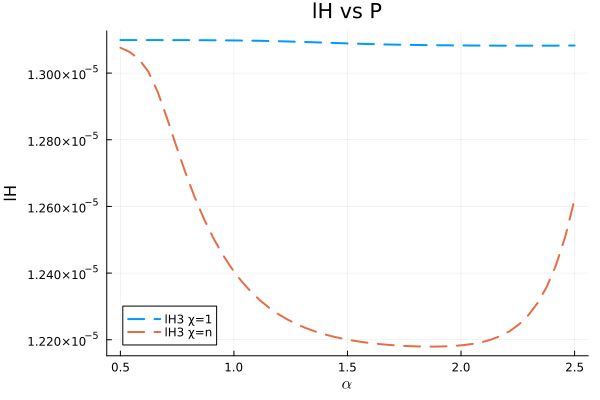

In [ ]:
# ---------------------------
# PLOTTING
# ---------------------------
plot(alphas, (lH3_series[1]), label="lH3 χ=1", lw=2, ls=:dash)
plot!(alphas, (lH3_series[n]), label="lH3 χ=n", lw=2, ls=:dash)
xlabel!(L"\alpha"); ylabel!("lH3"); title!("lH vs P")


## Scaling with D

In [ ]:
# Clean implementation of multiprocessing simulation for d scaling

# First, set up the correct number of workers (15 total processes = 14 workers)
using Distributed
if nprocs() > 15
    current_workers = workers()
    excess_count = nprocs() - 15
    workers_to_remove = current_workers[end-excess_count+1:end]
    rmprocs(workers_to_remove)
elseif nprocs() < 15
    addprocs(15 - nprocs())
end


In [26]:

println("Total processes: $(nprocs()), Workers: $(workers())")

@everywhere begin
    using NLsolve
    using Base 
    als = [2.1, 2.3, 2.4, 2.5] #range(2.0, stop=3.6, length=10)

    # Parameters
    kappa = 1.0
    delta = 1.0
    epsilon = 0.03
    b = 4 / (3 * π)
    const chi0 = 1e-4
    const annealing_steps = 500 # Increased annealing steps
    const prev_sol_initial = [1e-6, 1e-6, 4e-5, 4e-5, 1e-6, 1e-6, 1e-5, 1e-5, 1e-2]

    # System of equations
    function equations!(F, x, P, chi, d, kappa, delta, epsilon, n, b)
        lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT = x
        lWP = 1/d
        TrSigma = lWT + lWP*(d-1)

        EChh = lH1 + lH3 +
            (16 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3))*(d-1) +
            (4 / (π * (1 + 2*TrSigma)) * lWT)*(d-1)
        gammaYh2 = (4/π)/(1 + 2*EChh)
        lK1 = gammaYh2*lH1
        lK3 = gammaYh2*lH3

        F[1] = lT1 + chi^2 / (kappa / P + lK1)^2 * delta
        F[2] = lV1 - (lH1 / lJ1^2 - 1 / lJ1)
        F[3] = lH1 - 1 / (1/lJ1 + gammaYh2*lT1/(n*chi))
        F[4] = lJ1 - (4 / (π * (1 + 2*TrSigma)) * lWT)

        F[5] = lT3 + chi^2 / (kappa / P + lK3)^2 * delta
        F[6] = lV3 - (lH3 / lJ3^2 - 1 / lJ3)
        F[7] = lH3 - 1 / (1/lJ3 + gammaYh2*lT3*epsilon^2/(n*chi))
        F[8] = lJ3 - (16 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3))
        F[9] = lWT - 1 / (d + delta * b * lV1 / n)
    end

    # Physical solution check
    is_physical(sol) = all(sol[[3,4,7,8]] .> 0) && all(isfinite.(sol))  # Added finiteness check

    # Annealing solver
    function solve_with_annealing(final_chi::Float64, P_values::Vector{Float64},
                                  chi0::Float64, annealing_steps::Int64,
                                  initial_guess::Vector{Float64},
                                  d, kappa, delta, epsilon, n, b)
        chi_anneal_list = exp.(range(log(chi0), log(final_chi), length=annealing_steps))
        prev_sol = initial_guess
        sols = Vector{Union{Vector{Float64},Nothing}}(undef, length(P_values))

        for chi in chi_anneal_list
            new_prev_sol = prev_sol
            for (i, P) in enumerate(P_values)
                f!(F,x) = equations!(F, x, P, chi, d, kappa, delta, epsilon, n, b)
                try
                    sol = nlsolve(f!, new_prev_sol, ftol=1e-5, method=:newton).zero
                    if chi == final_chi
                        sols[i] = is_physical(sol) ? sol : nothing
                    end
                    new_prev_sol = sol
                catch
                    if chi == final_chi
                        sols[i] = nothing
                    end
                end
            end
            prev_sol = new_prev_sol
        end
        return (final_chi, sols)
    end

    # Function to solve for a single d value
    function solve_for_d(d_val::Int)
        n_val = round(Int, d_val * 1.5)  # n scales as d * 1.5
        # P_scaling = [d_val^0.5, d_val^1.0, d_val^1.2, d_val^1.5]  # Three P scalings

        P_scaling::Vector{Float64} =  d_val .^ collect(als)
        results_d = Vector{Union{Vector{Float64},Nothing}}(undef, length(P_scaling))
        n_val_float = Float64(n_val)
        for (i, P) in enumerate(P_scaling)
            # Solve with annealing at chi=1.0
            _, sols = solve_with_annealing(1.0, [P], chi0, annealing_steps,
                                         prev_sol_initial, d_val, kappa, delta,
                                         epsilon, n_val, b)

            results_d[i] = try
                !isempty(sols) && sols[1] !== nothing ? sols[1] : nothing
            catch
                nothing
            end
        end

        return (d_val, results_d)

    end
end

# Generate d values (log-spaced from 40 to 3000)
d_values = round.(Int, exp.(range(log(40), log(1e5), length=30)))  # Reduced number of points for higher quality solutions

println("Starting multiprocessing simulation with $(nworkers()) workers...")
println("Solving for $(length(d_values)) d values: $(d_values[1]) to $(d_values[end])")

# Run parallel computation
parallel_results = pmap(solve_for_d, d_values)


Total processes: 1, Workers: [1]
Starting multiprocessing simulation with 1 workers...
Solving for 30 d values: 40 to 100000


Total processes: 1, Workers: [1]
Starting multiprocessing simulation with 1 workers...
Solving for 30 d values: 40 to 100000


30-element Vector{Tuple{Int64, Vector{Union{Nothing, Vector{Float64}}}}}:
 (40, [[-4338.220839991629, 102.30378129264298, 0.021543042718089656, 0.010424873549309027, -4.706275628232997e6, 48.43337849024881, 4.201694904657283e-5, 4.193178984801477e-5, 0.024555754948258172], [-4382.486599253667, 104.42707398642233, 0.02176178785000977, 0.010421093099749824, -1.8021185843264893e7, 186.51630930397076, 4.221342233203629e-5, 4.188618827683322e-5, 0.024546701919115056], [-4394.945939841429, 105.03233479630062, 0.02182408367700436, 0.010420015955852393, -3.3802787393165424e7, 352.25399929510274, 4.249083114159746e-5, 4.187320131230097e-5, 0.024544122506455837], [-4403.548899500586, 105.45218016495258, 0.02186728041543467, 0.010419268914730658, -6.079624599831235e7, 641.0865416884603, 4.298777118581425e-5, 4.186419592473552e-5, 0.02454233358882132]])
 (52, [[-7312.058639686311, 133.26815145930564, 0.01668913239283176, 0.008050960983040633, -1.4525080034161499e7, 115.19321016649808, 1.9357057783

Detected 4 P-scalings in the data.


Detected 4 P-scalings in the data.


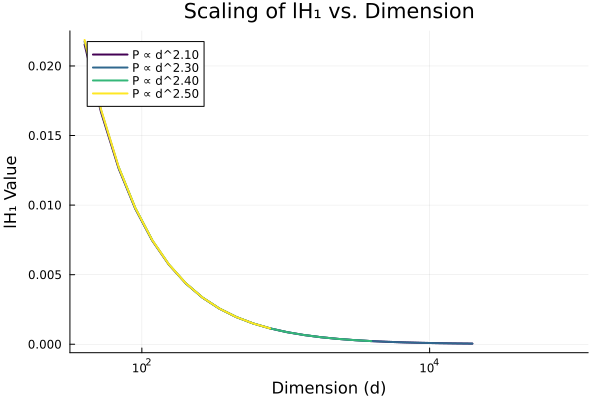

Detected 4 P-scalings in the data.


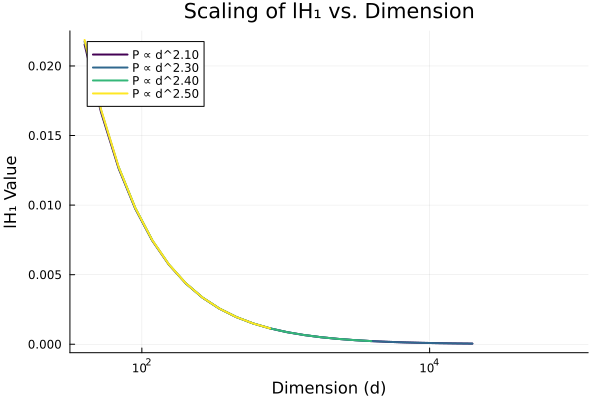

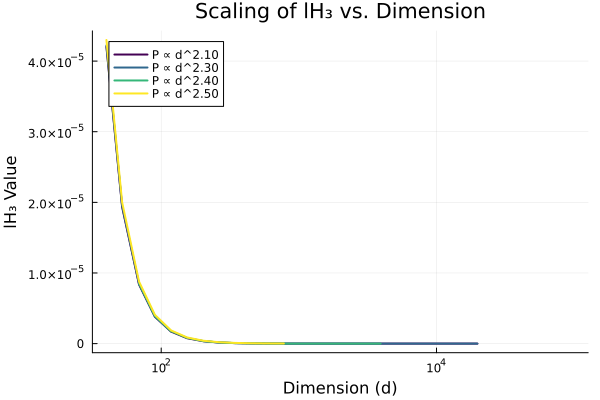

Detected 4 P-scalings in the data.


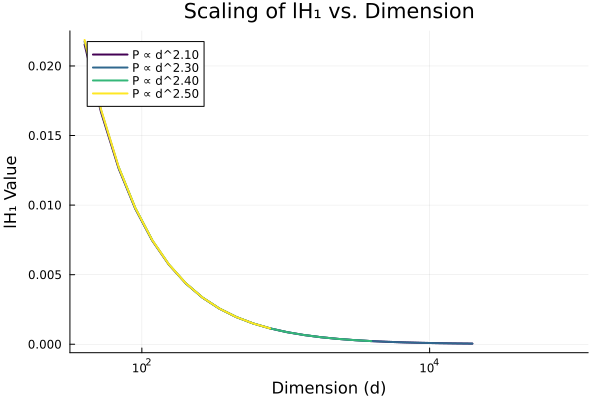

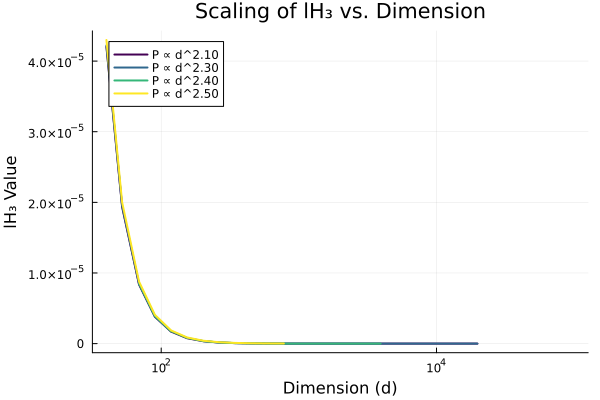

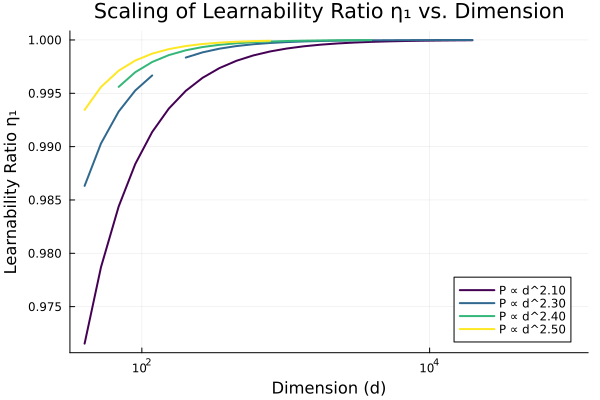

Detected 4 P-scalings in the data.


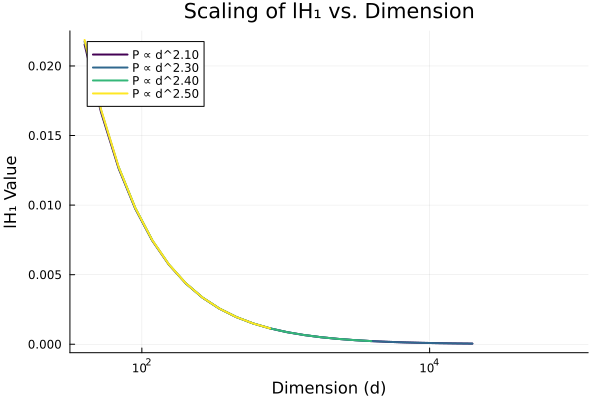

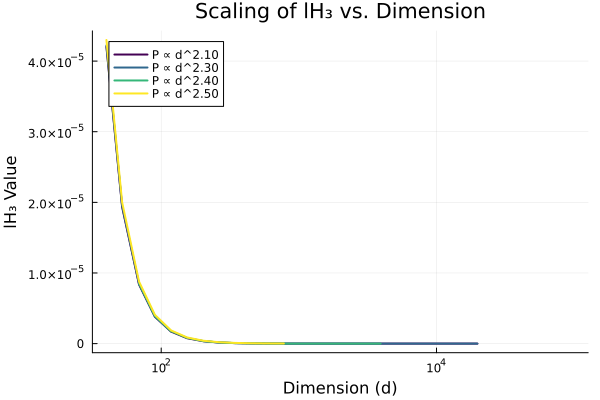

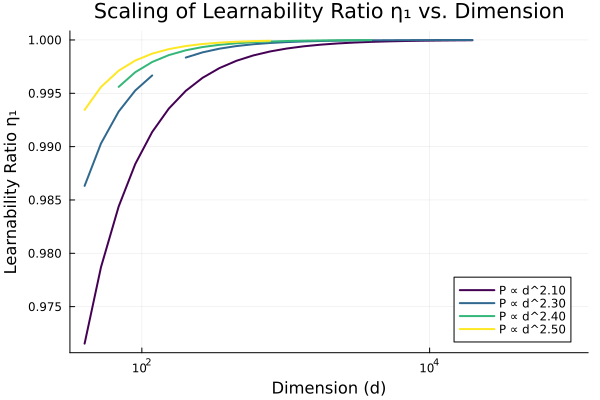

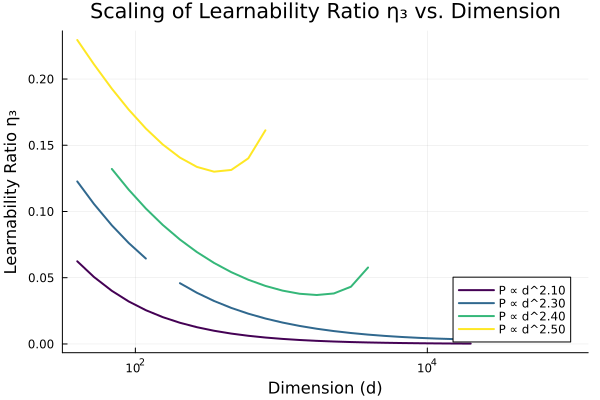

In [27]:
using Plots
using Printf 
using ColorSchemes # A good package for color gradients, often works well with Plots.jl

# --- (The compute_lK_ratio function and data processing section remain the same) ---
# Assuming 'compute_lK_ratio', 'parallel_results', and 'kappa' are available.

# Unpack results into a dictionary keyed by d value
d_results = Dict(r[1] => r[2] for r in parallel_results)
d_values = sort(collect(keys(d_results)))

# 🔑 DYNAMIC SIZING: Determine the number of P-scalings from the first successful result
# NOTE: The line below was statically set to '9' in your input. 
# Revert to the dynamic search or confirm a known valid index.
# For robustness, we will use the dynamic search here, or assume it works:
first_valid_results = 10 #findfirst(x -> !isempty(x) && any(r -> r isa Vector{Float64}, x), values(d_results))

if isnothing(first_valid_results)
    error("All solutions failed to converge or parallel_results is empty. Cannot plot.")
end

num_p_scalings = length(collect(values(d_results))[first_valid_results])
println("Detected $num_p_scalings P-scalings in the data.")

# Initialize storage for all variables (dynamically sized)
lH1_scaled = [Float64[] for _ in 1:num_p_scalings]
lH3_scaled = [Float64[] for _ in 1:num_p_scalings]
eta1_scaled = [Float64[] for _ in 1:num_p_scalings]
eta3_scaled = [Float64[] for _ in 1:num_p_scalings]

# CRITICAL UPDATE: Define P_exponents
# Your solver used: P_exponents = range(0.1, stop=2.0, length=10)
P_exponents = als #range(0.1, stop=2.0, length=num_p_scalings) # Adjusted length for robustness

# Trim exponents just in case the data is truncated or a subset is passed
P_exponents = P_exponents[1:min(length(P_exponents), num_p_scalings)] 

# Define labels dynamically using the exponents
P_labels = [@sprintf("P ∝ d^%.2f", exp) for exp in P_exponents] # Changed to .2f for range precision

# Loop through all d values
for d_val in d_values
    d_val_float = Float64(d_val)
    # Recalculate P-scalings using the defined exponents
    P_scalings = [d_val_float^exp for exp in P_exponents]
    
    sols_d = d_results[d_val] 

    for i in 1:num_p_scalings
        sol = sols_d[i]
        P = P_scalings[i]
        
        # NOTE: You MUST have the compute_lK_ratio function defined for this to run
        if sol !== nothing
            lH1, lH3 = sol[3], sol[7]
            eta1, eta3 = compute_lK_ratio(sol, P, d_val_float, kappa)
            
            push!(lH1_scaled[i], lH1)
            push!(lH3_scaled[i], lH3)
            push!(eta1_scaled[i], eta1)
            push!(eta3_scaled[i], eta3)
        else
            # Use NaN for failed points to maintain alignment with d_values
            push!(lH1_scaled[i], NaN); push!(lH3_scaled[i], NaN)
            push!(eta1_scaled[i], NaN); push!(eta3_scaled[i], NaN)
        end
    end
end

# ----------------------------------------------------
# 2. Visualization (Color-mapped and Marker-fixed)
# ----------------------------------------------------

# 🎨 Colormap setup: Define the color gradient and normalize the exponents
# Use a perceptually uniform colormap like :viridis or :jet
color_map = cgrad(:viridis, num_p_scalings, categorical=true) 
min_exp, max_exp = extrema(P_exponents)
exp_range = max_exp - min_exp
get_color(exp) = color_map[(exp - min_exp) / exp_range] # Function to map exponent to color (normalized)


## Plot A: Scaling of lH₁ vs. d
lH1_plot = plot(xlabel="Dimension (d)", 
                ylabel="lH₁ Value", 
                title="Scaling of lH₁ vs. Dimension", 
                xscale=:log10, 
                legend=:topleft)

for i in 1:num_p_scalings 
    color_val = get_color(P_exponents[i])
    plot!(lH1_plot, d_values, lH1_scaled[i], 
          label="$(P_labels[i])", 
          lw=2, 

          color=color_val)
end
display(lH1_plot)

## Plot B: Scaling of lH₃ vs. d
lH3_plot = plot(xlabel="Dimension (d)", 
                ylabel="lH₃ Value", 
                title="Scaling of lH₃ vs. Dimension", 
                xscale=:log10, 
                legend=:topleft)

for i in 1:num_p_scalings 
    color_val = get_color(P_exponents[i])
    plot!(lH3_plot, d_values, lH3_scaled[i], 
          label="$(P_labels[i])", 
          lw=2, 

          color=color_val)
end
display(lH3_plot)

## Plot C: Scaling of Coupling Ratio η₁ vs. d
eta1_plot = plot(xlabel="Dimension (d)", 
                ylabel="Learnability Ratio η₁", 
                title="Scaling of Learnability Ratio η₁ vs. Dimension", 
                xscale=:log10, 
                legend=:bottomright)

for i in 1:num_p_scalings 
    color_val = get_color(P_exponents[i])
    plot!(eta1_plot, d_values, eta1_scaled[i], 
          label="$(P_labels[i])", 
          lw=2, 
        #   markershape=:circle, 
          color=color_val)
end
display(eta1_plot)

## Plot D: Scaling of Coupling Ratio η₃ vs. d
eta3_plot = plot(xlabel="Dimension (d)", 
                ylabel="Learnability Ratio η₃", 
                title="Scaling of Learnability Ratio η₃ vs. Dimension", 
                xscale=:log10, 
                legend=:bottomright)

for i in 1:num_p_scalings 
    color_val = get_color(P_exponents[i])
    plot!(eta3_plot, d_values, eta3_scaled[i], 
          label="$(P_labels[i])", 
          lw=2, 

          color=color_val)
end
display(eta3_plot)

In [17]:
# ---------------------------
# ANNEALING PARAMETERS
# ---------------------------
const vars_len = 9  # lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT
const chi0 = 1e-8  # Initial chi value for annealing
const annealing_steps = 500  # Number of annealing steps
const prev_sol_initial = fill(0.1, vars_len)
chi_list = [1.0, n^0.2]  # Final chi values to solve for
alphas = range(0.5, 2.5, length=50)
P_values = [d^alpha for alpha in alphas]  # P values to sweep over

# ---------------------------
# SYSTEM OF EQUATIONS
# ---------------------------
function equations!(F, x, P, chi)
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT = x
    lWP = 1/d
    TrSigma = lWT + lWP*(d-1)
    
    EChh = lH1 + lH3 +
           (16 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3))*(d-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(d-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3

    F[1] = lT1 + chi^2 / (kappa / P + lK1)^2 * delta
    F[2] = lV1 - (lH1 / lJ1^2 - 1 / lJ1)
    F[3] = lH1 - 1 / (1/lJ1 + gammaYh2*lT1/(n*chi))
    F[4] = lJ1 - (4 / (π * (1 + 2*TrSigma)) * lWT)
    
    F[5] = lT3 + chi^2 / (kappa / P + lK3)^2 * delta
    F[6] = lV3 - (lH3 / lJ3^2 - 1 / lJ3)
    F[7] = lH3 - 1 / (1/lJ3 + gammaYh2*lT3*epsilon^2/(n*chi))
    F[8] = lJ3 - (16 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3))
    F[9] = lWT - 1 / (d + delta * b * lV1 / n)
end

compute_lK_ratio(sol, P, dval=d) = begin
    if sol === nothing
        return (NaN, NaN)
    end
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT = sol

    lWP = 1/d
    TrSigma = lWT + lWP*(d-1)
    EChh = lH1 + lH3 +
           (16/ (π * (1 + 2*TrSigma)^3) * (15*lWT^3))*(d-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(d-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3
    return (lK1/(lK1 + kappa/P), lK3/(lK3 + kappa/P))
end

# ---------------------------
# HELPER FUNCTIONS
# ---------------------------
is_physical(sol) = all(sol[[3,4,7,8]] .> 0)

# ---------------------------
# SOLVE WITH ANNEALING
# ---------------------------
results = Dict{Float64, Vector{Union{Vector{Float64},Nothing}}}()

for final_chi in chi_list
    # println("Solving for final_chi = $final_chi ...") 
    chi_anneal_list = exp.(range(log(chi0), log(final_chi), length=100))
    prev_sol = prev_sol_initial
    sols = Vector{Union{Vector{Float64},Nothing}}(undef, length(P_values))

    for chi in chi_anneal_list
        new_prev_sol = prev_sol
        
        for (i, P) in enumerate(P_values)
            f!(F,x) = equations!(F, x, P, chi)
            try
                sol = nlsolve(f!, new_prev_sol, method=:newton, xtol=1e-8).zero
                if chi == final_chi
                    sols[i] = is_physical(sol) ? sol : nothing
                end
                new_prev_sol = sol  # continuation within P sweep
            catch
                if chi == final_chi
                    sols[i] = nothing
                end
            end
        end
        prev_sol = new_prev_sol  # continuation across chi values
    end
    results[final_chi] = sols
end

# ---------------------------
# POSTPROCESS
# ---------------------------
function extract_series(var_idx)
    Dict(chi => [sol===nothing ? NaN : sol[var_idx] for sol in results[chi]] for chi in chi_list)
end


extract_series (generic function with 1 method)

In [18]:
results

Dict{Float64, Vector{Union{Nothing, Vector{Float64}}}} with 2 entries:
  3.98107 => [[-10382.7, 1.79811, 0.000634173, 0.000633452, -10618.8, 0.165321,…
  1.0     => [[-655.117, 0.451288, 0.000633633, 0.000633452, -670.0, 0.0415267,…

In [19]:

lH1_series = extract_series(3)
lH3_series = extract_series(7)
lJ1_series = extract_series(4)
lJ3_series = extract_series(8)

lK_ratio = Dict(chi => [compute_lK_ratio(sol, P_values[i]) for (i,sol) in enumerate(results[chi])] for chi in chi_list)

Dict{Float64, Vector{Tuple{Float64, Float64}}} with 2 entries:
  3.98107 => [(0.0111783, 1.67695e-7), (0.0145407, 2.1871e-7), (0.0189052, 2.85…
  1.0     => [(0.0111689, 1.67695e-7), (0.0145201, 2.18711e-7), (0.0188602, 2.8…

## Annealing Without Multiprocessing

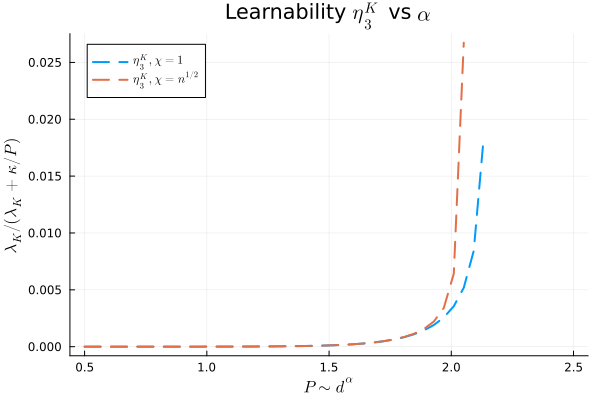

In [21]:

plot(alphas, [r[2] for r in lK_ratio[1]], label=L"\eta^K_3,\chi=1", lw=2, ls=:dash)
plot!(alphas, [r[2] for r in lK_ratio[n^0.2]], label=L"\eta^K_3, \chi=n^{1/2}", lw=2, ls=:dash)
# plot!(alphas, [r[2] for r in lK_ratio[n]], label=L"\eta^K_3 \chi=n", lw=2, ls=:dash)
xlabel!(L"$P \sim d^\alpha$"); ylabel!(L"\lambda_K/(\lambda_K + \kappa/P)"); 
title!("Learnability " * L" \eta^K_3 " * " vs " *L" \alpha ")


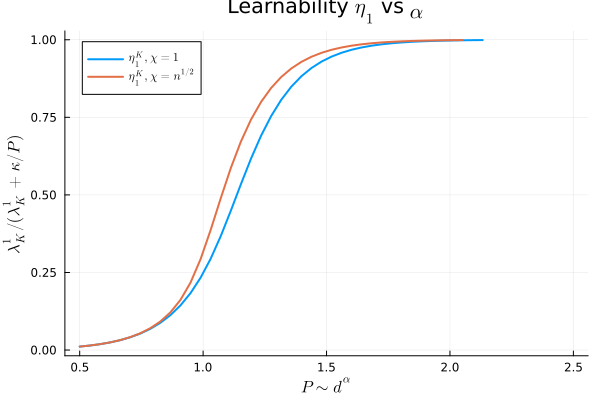

In [23]:
plot(alphas, [r[1] for r in lK_ratio[1]], label=L"\eta^K_1,\chi=1", lw=2)
plot!(alphas, [r[1] for r in lK_ratio[n^0.2]], label=L"\eta^K_1, \chi=n^{1/2}", lw=2)
# plot!(alphas, [r[1] for r in lK_ratio[n]], label=L"\eta^K_1 \chi=n", lw=2)
xlabel!(L"$P \sim d^\alpha$"); ylabel!(L"\lambda_K^1/(\lambda_K^1 + \kappa/P)"); 
title!("Learnability " * L" \eta_1" * " vs " *L" \alpha ")

In [29]:
const vars_len = 9  # lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT
const chi0 = 1e-8  # Initial chi value for annealing
const annealing_steps = 500  # Number of annealing steps
const prev_sol_initial = fill(0.1, vars_len)
chi_list = [1.0, n^0.5, n]  # Final chi values to solve for
alphas = range(0.5, 2.5, length=50)
P_values = [d^alpha for alpha in alphas]  # P values to sweep over

# ---------------------------
# ---------------------------
# SYSTEM OF EQUATIONS
# ---------------------------
function equations!(F, x, P, n, chi,d,delta,kappa,epsilon, b)
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT = x
    lWP = 1/d
    TrSigma = lWT + lWP*(d-1)
    
    EChh = lH1 + lH3 +
           (16 / (π * (1 + 2*TrSigma)^(3)) * (15*lWT^3))*(d-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(d-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3

    F[1] = lT1 + chi^2 / (kappa / P + lK1)^2 * delta
    F[2] = lV1 - (lH1 / lJ1^2 - 1 / lJ1)
    F[3] = lH1 - 1 / (1/lJ1 + gammaYh2*lT1/(n*chi))
    F[4] = lJ1 - (4 / (π * (1 + 2*TrSigma)) * lWT)
    
    F[5] = lT3 + chi^2 / (kappa / P + lK3)^2 * delta
    F[6] = lV3 - (lH3 / lJ3^2 - 1 / lJ3)
    F[7] = lH3 - 1 / (1/lJ3 + gammaYh2*lT3*epsilon^2/(n*chi))
    F[8] = lJ3 - (16 / (π * (1 + 2*TrSigma)^(3)) * (15*lWT^3))
    F[9] = lWT - 1 / (d + delta * b * lV1 / n)
end

compute_lK_ratio(sol, P, n, chi,d,delta,kappa,epsilon, b) = begin
    if sol === nothing
        return (NaN, NaN)
    end
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT = sol

    lWP = 1/d
    TrSigma = lWT + lWP*(d-1)
    EChh = lH1 + lH3 +
           (16/ (π * (1 + 2*TrSigma)^3) * (15*lWT^3))*(d-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(d-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3
    return (lK1/(lK1 + kappa/P), lK3/(lK3 + kappa/P))
end

# ---------------------------
# HELPER FUNCTIONS
# ---------------------------
is_physical(sol) = all(sol[[3,4,7,8]] .> 0)

function solve_with_annealing(final_chi::Float64, P_values::Vector{Float64},
                                  chi0::Float64, annealing_steps::Int64,
                                  initial_guess::Vector{Float64},
                                  d, kappa, delta, epsilon, n, b)
        chi_anneal_list = exp.(range(log(chi0), log(final_chi), length=annealing_steps))
        prev_sol = initial_guess
        sols = Vector{Union{Vector{Float64},Nothing}}(undef, length(P_values))

        for chi in chi_anneal_list
            new_prev_sol = prev_sol
            for (i, P) in enumerate(P_values)
                f!(F,x) = equations!(F, x, P, chi, d, kappa, delta, epsilon, n, b)
                try
                    sol = nlsolve(f!, new_prev_sol, ftol=1e-5, method=:newton).zero
                    if chi == final_chi
                        sols[i] = is_physical(sol) ? sol : nothing
                    end
                    new_prev_sol = sol
                catch
                    if chi == final_chi
                        sols[i] = nothing
                    end
                end
            end
            prev_sol = new_prev_sol
        end
        return (final_chi, sols)
    end

# Function to solve for a single set of parameters
function solve_single_point(;P::Int, d::Int, n::Int, 
                           kappa::Float64=1.0, delta::Float64=1.0, 
                           epsilon::Float64=0.003, b::Float64=4/(3*π),
                           final_chi::Float64=1.0)
    
    # Annealing parameters
    chi0 = 1e-8
    annealing_steps = 300
    prev_sol = [1e-6, 1e-6, 4e-5, 4e-5, 1e-6, 1e-6, 1e-5, 1e-5, 1e-2]
    
    # Create annealing schedule
    chi_anneal_list = exp.(range(log(chi0), log(final_chi), length=annealing_steps))
    
    # Solve with annealing
    local solution = nothing
    
    for chi in chi_anneal_list
            new_prev_sol = prev_sol
            for (i, P) in enumerate(P_values)
                f!(F,x) = equations!(F, x, P, chi, d, kappa, delta, epsilon, n, b)
                try
                    sol = nlsolve(f!, new_prev_sol, ftol=1e-5, method=:newton).zero
                    if chi == final_chi
                        solution = is_physical(sol) ? sol : nothing
                    end
                    new_prev_sol = sol
                catch
                    if chi == final_chi
                        solution = nothing
                    end
                end
            end
            prev_sol = new_prev_sol
        end

    if solution === nothing
        return (;status="No physical solution found")
    end
    
    # Extract components
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT = solution
    
    # Calculate learnabilities
    lK_ratios = compute_lK_ratio(solution, P, n, final_chi,d,delta,kappa,epsilon, b)
    η1, η3 = lK_ratios
    
    return (;
        status="Solution found",
        λH1=lH1, λH3=lH3,
        λJ1=lJ1, λJ3=lJ3,
        λT1=lT1, λT3=lT3,
        λV1=lV1, λV3=lV3,
        λWT=lWT,
        η1=η1, η3=η3
    )
end

# Example usage:
d = 65
n = 200
P = 100  # Using P ~ d^1.0 scaling

result = solve_single_point(P=P, d=d, n=n, final_chi=1.0)#Float64(n_test))

# Pretty print results
println("Results for parameters:")
println("d = $d")
println("n = $n")
println("P = $P")
println("\nSolution status: $(result.status)")
if result.status == "Solution found"
    println("\nEigenvalues:")
    println("λH1 = $(round(result.λH1, digits=8))")
    println("λH3 = $(round(result.λH3, digits=8))")
    println("λJ1 = $(round(result.λJ1, digits=8))")
    println("λJ3 = $(round(result.λJ3, digits=8))")
    println("\nLearnabilities:")
    println("η1 = $(round(result.η1, digits=8))")
    println("η3 = $(round(result.η3, digits=8))")
end

Results for parameters:
d = 650
n = 800
P = 145

Solution status: No physical solution found
d = 650
n = 800
P = 145

Solution status: No physical solution found


## Random Sampling Initial Conditions

In [2]:
# Load required packages on all workers
@everywhere using NonlinearSolve, LinearAlgebra

# Original functions: equations!, compute_lK_ratio, is_physical, solve_single_point
@everywhere function equations!(F,P, chi, d, kappa, delta, epsilon, n, b)
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT = F
    lWP = 1/d
    TrSigma = lWT + lWP*(d-1)
    EChh = lH1 + lH3 +
           (16 / (π * (1 + 2*TrSigma)^(3)) * (15*lWT^3))*(d-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(d-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3
    F[1] = lT1 + chi^2 / (kappa / P + lK1)^2 * delta
    F[2] = lV1 - (lH1 / lJ1^2 - 1 / lJ1)
    F[3] = lH1 - 1 / (1/lJ1 + gammaYh2*lT1/(n*chi))
    F[4] = lJ1 - (4 / (π * (1 + 2*TrSigma)) * lWT)
    F[5] = lT3 + chi^2 / (kappa / P + lK3)^2 * delta
    F[6] = lV3 - (lH3 / lJ3^2 - 1 / lJ3)
    F[7] = lH3 - 1 / (1/lJ3 + gammaYh2*lT3*epsilon^2/(n*chi))
    F[8] = lJ3 - (16 / (π * (1 + 2*TrSigma)^(3)) * (15*lWT^3))
    F[9] = lWT - 1 / (d + delta * b * lV1 / n)
    return F
end

@everywhere function compute_lK_ratio(sol, P, n, chi, d, delta, kappa, epsilon, b)
    if sol === nothing
        return (NaN, NaN)
    end
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT = sol
    lWP = 1/d
    TrSigma = lWT + lWP*(d-1)
    EChh = lH1 + lH3 +
           (16/ (π * (1 + 2*TrSigma)^3) * (15*lWT^3))*(d-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(d-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3
    return (lK1/(lK1 + kappa/P), lK3/(lK3 + kappa/P))
end

@everywhere function is_physical(sol)
    all(sol[[3,4,7,8]] .> 0)
end

@everywhere function solve_single_point(;P::Int, d::Int, n::Int, initial_guess::Vector{Float64},
                           kappa::Float64=1.0, delta::Float64=1.0,
                           epsilon::Float64=0.03, b::Float64=4/(3*π),
                           final_chi::Float64=1.0)
    chi0 = 1e-5
    annealing_steps = 100
    chi_anneal_list = exp.(range(log(chi0), log(final_chi), length=annealing_steps))
    prev_sol = initial_guess
    local solution = nothing
    for chi in chi_anneal_list
        new_prev_sol = prev_sol
        f!(x,prm) = equations!(x, P, chi, d, kappa, delta, epsilon, n, b)
        try
            prob = NonlinearSolve.NonlinearProblem(f!, new_prev_sol, nothing)
            sol = solve(prob,  GaussNewton(), reltol = 1e-8, abstol = 1e-8).u
            if chi == final_chi
                solution = is_physical(sol) ? sol : nothing
            end
            new_prev_sol = sol
        catch e
            println("Caught an error:")
            showerror(stdout, e) # Prints the error message
            println("\nStacktrace:")
            showerror(stdout, e, catch_backtrace()) # Prints the error message with stack trace
            if chi == final_chi
                solution = nothing
            end
        end
        prev_sol = new_prev_sol
    end
    if solution === nothing
        return (;status="No physical solution found")
    end
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT = solution
    lK_ratios = compute_lK_ratio(solution, P, n, final_chi, d, delta, kappa, epsilon, b)
    η1, η3 = lK_ratios
    return (;
            status="Solution found",
            λH1=lH1, λH3=lH3,
            λJ1=lJ1, λJ3=lJ3,
            λT1=lT1, λT3=lT3,
            λV1=lV1, λV3=lV3,
            λWT=lWT,
            η1=η1, η3=η3
        )
end

# Parameters
d = 25
n = 250
P = 35
kappa = 1.0
delta = 1.0
epsilon = 0.03
b = 4/(3*π)
final_chi = 1.0
initial_guess_mean = fill(0.1, 9)
num_samples = 100
std_dev = 0.01 # Standard deviation for normal distribution

# Generate 1000 random initial guesses
dist = MvNormal(initial_guess_mean, std_dev)
initial_guesses = rand(dist, num_samples)

# Store results
results = Vector{Any}(undef, num_samples)
success_count = 0
η1_values = Float64[]
η3_values = Float64[]

# Parallel computation using pmap
results = pmap(i -> solve_single_point(
    P=P, d=d, n=n, initial_guess=initial_guesses[:, i],
    kappa=kappa, delta=delta, epsilon=epsilon, b=b, final_chi=final_chi
), 1:num_samples)
rmprocs(workers())


Summary of Results:
Number of samples: 30
Number of successful solutions: 0
Success rate: 0.0%
No physical solutions found in any sample.
Number of samples: 30
Number of successful solutions: 0
Success rate: 0.0%
No physical solutions found in any sample.


In [31]:
import Pkg; Pkg.add("Distributions")

   Resolving package versions...
package versions...
    Updating `~/.julia/environments/v1.12/Project.toml`
  [31c24e10] + Distributions v0.25.122
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`
    Updating `~/.julia/environments/v1.12/Project.toml`
  [31c24e10] + Distributions v0.25.122
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`


In [ ]:

# Step 1: Clear existing workers and initialize maximum workers
rmprocs(workers())  # Remove existing workers
max_workers = 22  # Leave one core for master
addprocs(max_workers)

## Using Homotopy Continuation

In [74]:
import Pkg; Pkg.add("HomotopyContinuation")"

   Resolving package versions...
   Installed LRUCache ───────────────────────── v1.6.2
   Installed TreeViews ──────────────────────── v0.3.0
   Installed FLINT_jll ──────────────────────── v301.300.102+0
   Installed SciMLPublic ────────────────────── v1.0.0
   Installed OffsetArrays ───────────────────── v1.17.0
   Installed MutableArithmetics ─────────────── v1.6.7
   Installed Permutations ───────────────────── v0.4.23
   Installed LRUCache ───────────────────────── v1.6.2
   Installed TreeViews ──────────────────────── v0.3.0
   Installed FLINT_jll ──────────────────────── v301.300.102+0
   Installed SciMLPublic ────────────────────── v1.0.0
   Installed OffsetArrays ───────────────────── v1.17.0
   Installed MutableArithmetics ─────────────── v1.6.7
   Installed Permutations ───────────────────── v0.4.23
   Installed Multisets ──────────────────────── v0.4.5
   Installed Multisets ──────────────────────── v0.4.5
   Installed ProgressMeter ──────────────────── v1.11.0
   Installe

In [ ]:
using HomotopyContinuation
using Printf
using LinearAlgebra

# ---------------------------
# SYSTEM OF EQUATIONS
# ---------------------------
function define_system(P, n, chi, d, delta, kappa, epsilon, b)
    @var x[1:9] # lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT
    @var lWP TrSigma EChh gammaYh2 lK1 lK3
    
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT = x
    
    # Intermediate variables
    lWP_val = 1/d
    TrSigma_val = lWT + lWP_val*(d-1)
    EChh_val = lH1 + lH3 + 
               (16 / (pi * (1 + 2*TrSigma_val)^3) * (15*lWT^3))*(d-1) + 
               (4 / (pi * (1 + 2*TrSigma_val)) * lWT)*(d-1)
    gammaYh2_val = (4/pi)/(1 + 2*EChh_val)
    lK1_val = gammaYh2_val * lH1
    lK3_val = gammaYh2_val * lH3
    
    # System of equations
    F = [
        lT1 + chi^2 / (kappa / P + lK1_val)^2 * delta,
        lV1 - (lH1 / lJ1^2 - 1 / lJ1),
        lH1 - 1 / (1/lJ1 + gammaYh2_val*lT1/(n*chi)),
        lJ1 - (4 / (pi * (1 + 2*TrSigma_val)) * lWT),
        lT3 + chi^2 / (kappa / P + lK3_val)^2 * delta,
        lV3 - (lH3 / lJ3^2 - 1 / lJ3),
        lH3 - 1 / (1/lJ3 + gammaYh2_val*lT3*epsilon^2/(n*chi)),
        lJ3 - (16 / (pi * (1 + 2*TrSigma_val)^3) * (15*lWT^3)),
        lWT - 1 / (d + delta * b * lV1 / n)
    ]
    
    System(F, variables=x)
end

function compute_lK_ratio(sol, P, n, chi, d, delta, kappa, epsilon, b)
    if sol === nothing
        return (NaN, NaN)
    end
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT = sol
    lWP = 1/d
    TrSigma = lWT + lWP*(d-1)
    EChh = lH1 + lH3 + 
           (16 / (pi * (1 + 2*TrSigma)^3) * (15*lWT^3))*(d-1) + 
           (4 / (pi * (1 + 2*TrSigma)) * lWT)*(d-1)
    gammaYh2 = (4/pi)/(1 + 2*EChh)
    lK1 = gammaYh2 * lH1
    lK3 = gammaYh2 * lH3
    return (lK1/(lK1 + kappa/P), lK3/(lK3 + kappa/P))
end

# ---------------------------
# HELPER FUNCTIONS
# ---------------------------
is_physical(sol) = all(sol[[3,4,7,8]] .> 0)

function solve_single_point(;P::Int, d::Int, n::Int,
                           kappa::Float64=1.0, delta::Float64=1.0,
                           epsilon::Float64=0.003, b::Float64=4/(3*pi),
                           final_chi::Float64=1.0)
    chi0 = 1e-8
    
    # Define system at chi0
    system_chi0 = define_system(P, n, chi0, d, delta, kappa, epsilon, b)
    
    # Initial guess
    initial_guess = [1e-6, 1e-6, 4e-5, 4e-5, 1e-6, 1e-6, 1e-5, 1e-5, 1e-2]
    
    # Solve at chi0
    result_chi0 = solve(system_chi0, start_solutions=[initial_guess], show_progress=false)
    real_sols = real_solutions(result_chi0)
    physical_sols = [sol for sol in real_sols if is_physical(sol)]
    
    if isempty(physical_sols)
        return (;status="No physical solution found at chi0")
    end
    
    # Use the first physical solution
    start_sol = physical_sols[1]
    
    # Define system at final_chi
    system_final = define_system(P, n, final_chi, d, delta, kappa, epsilon, b)
    
    # Perform homotopy continuation
    result_final = solve(system_chi0, system_final, start_solutions=[start_sol], show_progress=false)
    final_sols = real_solutions(result_final)
    final_physical_sols = [sol for sol in final_sols if is_physical(sol)]
    
    if isempty(final_physical_sols)
        return (;status="No physical solution found at final_chi")
    end
    
    # Use the first physical solution at final_chi
    solution = final_physical_sols[1]
    
    # Extract components
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT = solution
    
    # Calculate learnabilities
    lK_ratios = compute_lK_ratio(solution, P, n, final_chi, d, delta, kappa, epsilon, b)
    η1, η3 = lK_ratios
    
    return (;
        status="Solution found",
        λH1=lH1, λH3=lH3,
        λJ1=lJ1, λJ3=lJ3,
        λT1=lT1, λT3=lT3,
        λV1=lV1, λV3=lV3,
        λWT=lWT,
        η1=η1, η3=η3
    )
end

# Example usage:
d_test = 65
n_test = 250
P_test = 100 # Using P ~ d^1.0 scaling
result = solve_single_point(P=P_test, d=d_test, n=n_test, final_chi=1.0)

# Pretty print results
println("Results for parameters:")
println("d = $d_test")
println("n = $n_test")
println("P = $P_test")
println("\nSolution status: $(result.status)")
if result.status == "Solution found"
    println("\nEigenvalues:")
    @printf("λH1 = %.6f\n", result.λH1)
    @printf("λH3 = %.6f\n", result.λH3)
    @printf("λJ1 = %.6f\n", result.λJ1)
    @printf("λJ3 = %.6f\n", result.λJ3)
    println("\nLearnabilities:")
    @printf("η1 = %.6f\n", result.η1)
    @printf("η3 = %.6f\n", result.η3)
end

## Everything Everywhere all at Once    


In [47]:
using NLsolve
using Printf

# ---------------------------
# SYSTEM OF EQUATIONS
# ---------------------------
function equations!(F, x, P, n, chi, d, kappa, epsilon, b)
    # Variables: lT1_T, lV1_T, lH1_T, lJ1_T, lT3_T, lV3_T, lH3_T, lJ3_T, lWT_T (for delta=1)
    #            lT1_P, lV1_P, lH1_P, lJ1_P, lT3_P, lV3_P, lH3_P, lJ3_P, lWT_P (for delta=0)
    lT1_T, lV1_T, lH1_T, lJ1_T, lT3_T, lV3_T, lH3_T, lJ3_T, lWT_T,
    lT1_P, lV1_P, lH1_P, lJ1_P, lT3_P, lV3_P, lH3_P, lJ3_P, lWT_P = x
    
    # Common calculations
    lWP = 1/d
    TrSigma_T = lWT_T + lWP*(d-1)
    TrSigma_P = lWT_P + lWP*(d-1)
    EChh = lH3_T + (d-1) * lH3_P + lH1_T + lH1_P * (d-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1_T = gammaYh2 * lH1_T
    lK3_T = gammaYh2 * lH3_T
    lK1_P = gammaYh2 * lH1_P
    lK3_P = gammaYh2 * lH3_P
    
    # Equations for delta=1 (Target)
    F[1] = lT1_T + chi^2 / (kappa / P + lK1_T)^2
    F[2] = lV1_T - (lH1_T / lJ1_T^2 - 1 / lJ1_T)
    F[3] = lH1_T - 1 / (1/lJ1_T + gammaYh2*lT1_T/(n*chi))
    F[4] = lJ1_T - (4 / (π * (1 + 2*TrSigma_T)) * lWT_T)
    F[5] = lT3_T + chi^2 / (kappa / P + lK3_T)^2
    F[6] = lV3_T - (lH3_T / lJ3_T^2 - 1 / lJ3_T)
    F[7] = lH3_T - 1 / (1/lJ3_T + gammaYh2*lT3_T*epsilon^2/(n*chi))
    F[8] = lJ3_T - (16 / (π * (1 + 2*TrSigma_T)^3) * (15*lWT_T^3))
    F[9] = lWT_T - 1 / (d + b * lV1_T / n)
    
    # Equations for delta=0 (Perpendicular)
    F[10] = lT1_P
    F[11] = lV1_P - (lH1_P / lJ1_P^2 - 1 / lJ1_P)
    F[12] = lH1_P - 1 / (1/lJ1_P + gammaYh2*lT1_P/(n*chi))
    F[13] = lJ1_P - (4 / (π * (1 + 2*TrSigma_P)) * lWT_P)
    F[14] = lT3_P
    F[15] = lV3_P - (lH3_P / lJ3_P^2 - 1 / lJ3_P)
    F[16] = lH3_P - 1 / (1/lJ3_P + gammaYh2*lT3_P*epsilon^2/(n*chi))
    F[17] = lJ3_P - (16 / (π * (1 + 2*TrSigma_P)^3) * (15*lWT_P^3))
    F[18] = lWT_P - 1 / (d + 0 * b * lV1_P / n)
end

function compute_lK_ratio(sol, P, n, chi, d, kappa, epsilon, b)
    if sol === nothing
        return (NaN, NaN, NaN, NaN)
    end
    lT1_T, lV1_T, lH1_T, lJ1_T, lT3_T, lV3_T, lH3_T, lJ3_T, lWT_T,
    lT1_P, lV1_P, lH1_P, lJ1_P, lT3_P, lV3_P, lH3_P, lJ3_P, lWT_P = sol
    
    lWP = 1/d
    EChh = lH3_T + (d-1) * lH3_P
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1_T = gammaYh2 * lH1_T
    lK3_T = gammaYh2 * lH3_T
    lK1_P = gammaYh2 * lH1_P
    lK3_P = gammaYh2 * lH3_P
    
    return (lK1_T/(lK1_T + kappa/P), lK3_T/(lK3_T + kappa/P),
            lK1_P/(lK1_P + kappa/P), lK3_P/(lK3_P + kappa/P))
end

# ---------------------------
# HELPER FUNCTIONS
# ---------------------------
is_physical(sol) = all(sol[[3,4,7,8,12,13,16,17]] .> 0)

function solve_single_point(;P::Int, d::Int, n::Int,
                           kappa::Float64=1.0, epsilon::Float64=0.003,
                           b::Float64=4/(3*π), final_chi::Float64=1.0)
    # Annealing parameters
    chi0 = 1e-8
    annealing_steps = 100000
    prev_sol = fill(0.1, 18) # Initial guess for 18 variables
    
    # Create annealing schedule
    chi_anneal_list = exp.(range(log(chi0), log(final_chi), length=annealing_steps))
    
    # Solve with annealing
    local solution = nothing
    for chi in chi_anneal_list
        f!(F, x) = equations!(F, x, P, n, chi, d, kappa, epsilon, b)
        try
            sol = nlsolve(f!, prev_sol, method=:newton, xtol=1e-8).zero
            prev_sol = sol
            if chi == final_chi && is_physical(sol)
                solution = sol
            end
        catch e
            println("Caught an error: ", e)
            continue
        end
    end
    
    if solution === nothing
        return (;status="No physical solution found")
    end
    
    # Extract components
    lT1_T, lV1_T, lH1_T, lJ1_T, lT3_T, lV3_T, lH3_T, lJ3_T, lWT_T,
    lT1_P, lV1_P, lH1_P, lJ1_P, lT3_P, lV3_P, lH3_P, lJ3_P, lWT_P = solution
    
    # Calculate learnabilities
    lK_ratios = compute_lK_ratio(solution, P, n, final_chi, d, kappa, epsilon, b)
    η1_T, η3_T, η1_P, η3_P = lK_ratios
    
    return (;
        status="Solution found",
        λH1_T=lH1_T, λH3_T=lH3_T, λJ1_T=lJ1_T, λJ3_T=lJ3_T,
        λT1_T=lT1_T, λT3_T=lT3_T, λV1_T=lV1_T, λV3_T=lV3_T, λWT_T=lWT_T,
        λH1_P=lH1_P, λH3_P=lH3_P, λJ1_P=lJ1_P, λJ3_P=lJ3_P,
        λT1_P=lT1_P, λT3_P=lT3_P, λV1_P=lV1_P, λV3_P=lV3_P, λWT_P=lWT_P,
        η1_T=η1_T, η3_T=η3_T, η1_P=η1_P, η3_P=η3_P
    )
end

# Example usage:
d_test = 25
n_test = 250
P_test = 35 # Using P ~ d^1.0 scaling
result = solve_single_point(P=P_test, d=d_test, n=n_test, final_chi=1.0)

# Pretty print results
println("Results for parameters:")
println("d = $d_test")
println("n = $n_test")
println("P = $P_test")
println("\nSolution status: $(result.status)")
if result.status == "Solution found"
    println("\nEigenvalues (Target, delta=1):")
    println("λH1_T = $(round(result.λH1_T, digits=8))")
    println("λH3_T = $(round(result.λH3_T, digits=8))")
    println("λJ1_T = $(round(result.λJ1_T, digits=8))")
    println("λJ3_T = $(round(result.λJ3_T, digits=8))")
    println("\nEigenvalues (Perpendicular, delta=0):")
    println("λH1_P = $(round(result.λH1_P, digits=8))")
    println("λH3_P = $(round(result.λH3_P, digits=8))")
    println("λJ1_P = $(round(result.λJ1_P, digits=8))")
    println("λJ3_P = $(round(result.λJ3_P, digits=8))")
    println("\nLearnabilities (Target, delta=1):")
    println("η1_T = $(round(result.η1_T, digits=8))")
    println("η3_T = $(round(result.η3_T, digits=8))")
    println("\nLearnabilities (Perpendicular, delta=0):")
    println("η1_P = $(round(result.η1_P, digits=8))")
    println("η3_P = $(round(result.η3_P, digits=8))")
end

Results for parameters:
d = 25
n = 250
P = 35

Solution status: Solution found

Eigenvalues (Target, delta=1):
λH1_T = 0.01746901
λH3_T = 0.00018102
λJ1_T = 0.0169746
λJ3_T = 0.00018102

Eigenvalues (Perpendicular, delta=0):
λH1_P = 0.01697653
λH3_P = 0.00018108
λJ1_P = 0.01697653
λJ3_P = 0.00018108

Learnabilities (Target, delta=1):
η1_T = 0.43550448
η3_T = 0.00793114

Learnabilities (Perpendicular, delta=0):
η1_P = 0.4284876
η3_P = 0.00793381
d = 25
n = 250
P = 35

Solution status: Solution found

Eigenvalues (Target, delta=1):
λH1_T = 0.01746901
λH3_T = 0.00018102
λJ1_T = 0.0169746
λJ3_T = 0.00018102

Eigenvalues (Perpendicular, delta=0):
λH1_P = 0.01697653
λH3_P = 0.00018108
λJ1_P = 0.01697653
λJ3_P = 0.00018108

Learnabilities (Target, delta=1):
η1_T = 0.43550448
η3_T = 0.00793114

Learnabilities (Perpendicular, delta=0):
η1_P = 0.4284876
η3_P = 0.00793381
